<a href="https://colab.research.google.com/github/j-ranasinghe/nlp_cw/blob/main/Solution_GroupH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CM4603 – Coursework 1 (Group)
#### November 2023

### Group: H

Name 1: Anuttara Rajasinghe |
IIT ID: 20210216 |
RGU ID: 2117946

Name 2: Janani  Ranasinghe |
IIT ID: 20210926 |
RGU ID: 2122095

Name 3: Vishmi Herath |
IIT ID: 20210503 |
RGU ID: 2117528

In [1]:
import json
import nltk
import re
import spacy
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from google.colab import drive
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, GPT2Tokenizer, AutoTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from transformers import pipeline

In [2]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/NLP CW/full-combined-dataset.json'

# Load the JSON data
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)


### Answer to Task 1

    Describe the dataset, any insights you gained about the data and the effectiveness of the different (subword) tokenization schemes tried out.

## **Raw data**

In [5]:
#Raw dataset before cleaning
print('Raw dataset before cleaning :\n')
data[:1]

Raw dataset before cleaning :



[{'id': '974611685',
  'url': 'https://www.tripadvisor.com/ShowUserReviews-g616035-d4465330-r974611685-Ella_Jungle_Resort-Ella_Uva_Province.html',
  'title': 'Terrible experience. Waste of time, money and nerves. Stay away.',
  'lang': 'en',
  'locationId': '4465330',
  'publishedDate': '2024-10-19',
  'publishedPlatform': 'OTHER',
  'rating': 1,
  'helpfulVotes': 1,
  'text': 'Well, no.   Big no. \nFirst of all, before booking, please go through all these comments. Look at the pictures. Not posted by the property but from guest. The place have a great potential but as of today it is just a scam. Place is undeveloped, rooms are nasty. Food terrible. All three above aspects can be fixed easily and reading that this "in a jungle" makes no sense. We travel to Sri Lanka often, staying in boutique hotels but also in a real jungle. All places can be clean and nice disputing the fact of not easy environment around. Same w/ food. Staying "in a jungle" explain nasty food served? Having so many 

## **Data Cleaning**

Extract only the specified columns




In [6]:
filtered_data = []
for entry in data:
    filtered_entry = {
        "title": entry.get("title"),
        "lang": entry.get("lang"),
        "Date": entry.get("travelDate"),
        "rating": entry.get("rating"),
        "helpfulVotes": entry.get("helpfulVotes"),
        "text": entry.get("text"),
        "PlaceName": entry.get("placeInfo", {}).get("name"),
        "PlaceRating": entry.get("placeInfo", {}).get("rating")
    }
    filtered_data.append(filtered_entry)


In [7]:
filtered_data[:1]

[{'title': 'Terrible experience. Waste of time, money and nerves. Stay away.',
  'lang': 'en',
  'Date': '2024-08',
  'rating': 1,
  'helpfulVotes': 1,
  'text': 'Well, no.   Big no. \nFirst of all, before booking, please go through all these comments. Look at the pictures. Not posted by the property but from guest. The place have a great potential but as of today it is just a scam. Place is undeveloped, rooms are nasty. Food terrible. All three above aspects can be fixed easily and reading that this "in a jungle" makes no sense. We travel to Sri Lanka often, staying in boutique hotels but also in a real jungle. All places can be clean and nice disputing the fact of not easy environment around. Same w/ food. Staying "in a jungle" explain nasty food served? Having so many option for low-key or upscale Sri Lanka\' culinary possibilities? \n\nSo we did claim many times issues on site. Zero interest. Management\'s reaction: it is what it is, deal with it. \nImmediate decision to leave. Aft

In [8]:
print(len(filtered_data))

10127


Load the data into a DataFrame

In [11]:
df = pd.DataFrame(filtered_data)

In [12]:
df.head(1)

,title,lang,Date,rating,helpfulVotes,text,PlaceName,PlaceRating
0,"Terrible experience. Waste of time, money and ...",en,2024-08,1,1,"Well, no. Big no. \nFirst of all, before boo...",Ella Jungle Resort,4.0


In [13]:
# Description
description = {
    'row_count': df.shape[0],
    'column_count': df.shape[1],
    'unique_place_names': df['PlaceName'].nunique(),
}

# Adding columns for the review length in words and characters
df['review_length_words'] = df['text'].apply(lambda x: len(x.split()))
df['review_length_chars'] = df['text'].apply(len)

# Descriptive statistics for `rating`, `helpfulVotes`, and `PlaceRating`
descriptive_stats = df[['rating', 'helpfulVotes', 'PlaceRating']].describe()

review_length_stats = df['review_length_words'].agg(['min', 'max', 'mean'])


# Language distribution
lang_distribution = df['lang'].value_counts()

In [14]:
# Print each section with spacing for readability
print("Description of the Raw Dataset\n")
print( description, "\n")
print("Descriptive Statistics:\n", descriptive_stats, "\n")
print("Review Length Analysis:\n", review_length_stats, "\n")
print("Language Distribution:\n", lang_distribution.to_dict(), "\n")


Description of the Raw Dataset

{'row_count': 10127, 'column_count': 8, 'unique_place_names': 205} 

Descriptive Statistics:
              rating  helpfulVotes   PlaceRating
count  10127.000000  10127.000000  10127.000000
mean       4.648267      0.202232      4.537030
std        0.840836      1.006587      0.311669
min        1.000000     -1.000000      4.000000
25%        5.000000      0.000000      4.500000
50%        5.000000      0.000000      4.500000
75%        5.000000      0.000000      4.500000
max        5.000000     60.000000      5.000000 

Review Length Analysis:
 min        1.000000
max     1191.000000
mean      89.412067
Name: review_length_words, dtype: float64 

Language Distribution:
 {'en': 8966, 'de': 255, 'fr': 220, 'ru': 215, 'nl': 126, 'es': 113, 'it': 72, 'ja': 35, 'zhCN': 32, 'sv': 20, 'da': 20, 'no': 10, 'pl': 10, 'ar': 8, 'iw': 6, 'zhTW': 5, 'ko': 4, 'cs': 3, 'pt': 3, 'fi': 2, 'tr': 2} 



In [15]:
# Print duplicates if any
duplicates = df[df.duplicated(subset=['title', 'text'], keep=False)]

if not duplicates.empty:
    print("Duplicates found:")
    print(duplicates)
else:
    print("No duplicates found.")

No duplicates found.


In [16]:
def clean_text(text):
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Reduce repeated characters (like "loooove" to "loove")
    text = re.sub(r'(.)\1{2,}', r"\1\1", text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove trailing and extra whitespaces
    text = ' '.join(text.split())
    return text

In [17]:
# cleaning the dataset
df['text'] = df['text'].apply(clean_text)

In [18]:
# Drop rows where 'lang' is not 'en'
df = df[df['lang'] == "en"].reset_index(drop=True)

In [19]:
columns_to_drop = ['review_length_words','review_length_chars']
df.drop(columns=columns_to_drop, inplace=True)

In [20]:
#Calculate review length in words
df['review_length'] = df['text'].apply(lambda x: len(x.split()))

Box Plot of Review Lengths

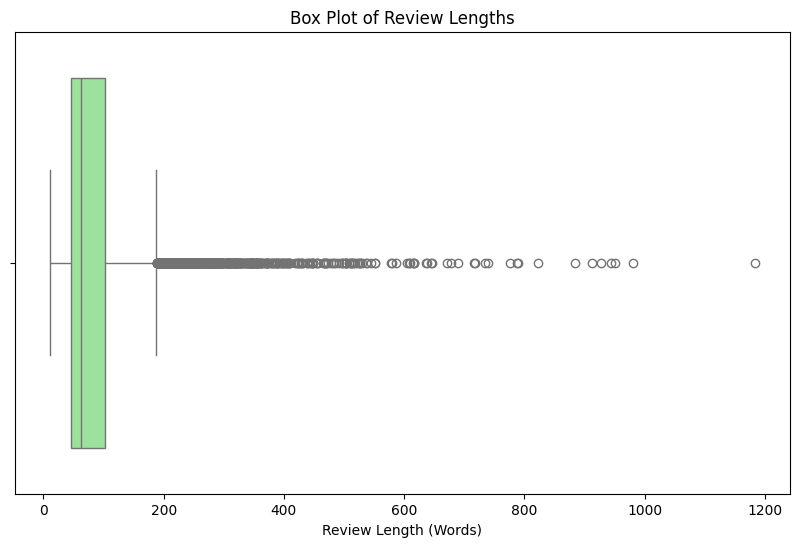

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['review_length'], color='lightgreen')
plt.title('Box Plot of Review Lengths')
plt.xlabel('Review Length (Words)')

plt.show()

In [22]:
#Calculate the mean and median for the review length
mean_length = df['review_length'].mean()
median_length = df['review_length'].median()

Plot the histogram for review length

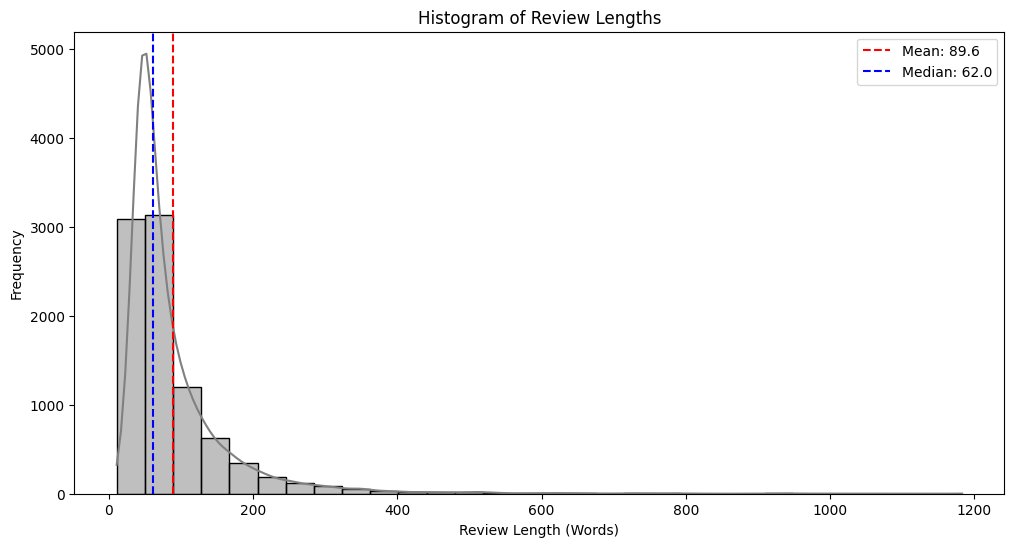

In [23]:
plt.figure(figsize=(12, 6))
sns.histplot(df['review_length'], bins= 30, kde=True, color="grey")
plt.axvline(mean_length, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='blue', linestyle='--', linewidth=1.5, label=f'Median: {median_length:.1f}')

plt.title("Histogram of Review Lengths")
plt.xlabel("Review Length (Words)")
plt.ylabel("Frequency")
plt.legend()

plt.show()

In [24]:
#Calculate the 5th and 95th percentiles of review lengths
lower_threshold = df['review_length'].quantile(0.02)
upper_threshold = df['review_length'].quantile(0.98)

In [25]:
#Threshold values for review lengths to drop
print(f"5th Percentile Threshold (Minimum Length): {lower_threshold}")
print(f"95th Percentile Threshold (Maximum Length): {upper_threshold}\n")

5th Percentile Threshold (Minimum Length): 31.0
95th Percentile Threshold (Maximum Length): 323.0



In [26]:
#Filter out the reviews below the 5th percentile and above the 95th percentile
lower_bound = df[df['review_length'] < lower_threshold]
upper_bound = df[df['review_length'] > upper_threshold]

In [27]:
#the number of reviews below the 5th and above the 95th percentiles
print(f"Number of reviews below the 2nd percentile: {len(lower_bound)}")
print(f"Number of reviews above the 98th percentile: {len(upper_bound)}")

Number of reviews below the 2nd percentile: 157
Number of reviews above the 98th percentile: 179


Histogram of Review Lengths Below the 2nd Percentile AND Review Lengths Above the 98th Percentile

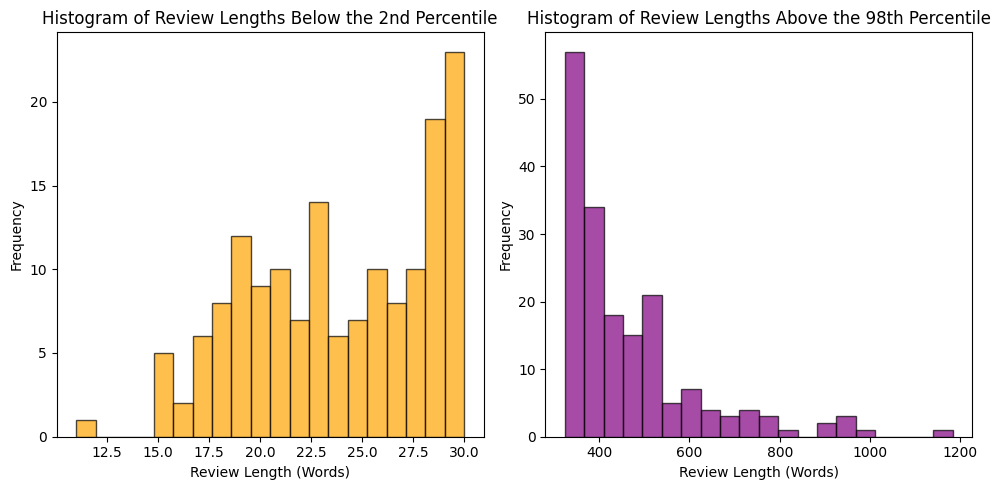

In [28]:
plt.figure(figsize=(10, 5))

# Plot histogram for reviews below the 5th percentile
plt.subplot(1, 2, 1)
plt.hist(lower_bound['review_length'], bins=20, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths Below the 2nd Percentile')

# Plot histogram for reviews above the 95th percentile
plt.subplot(1, 2, 2)
plt.hist(upper_bound['review_length'], bins=20, color='purple', edgecolor='black', alpha=0.7)
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths Above the 98th Percentile')

plt.tight_layout()
plt.show()

Drop the reviews less than teh 2nd percentile and higher than the 98th percentile

In [29]:
df_cleaned = df[(df['review_length'] >= lower_threshold) & (df['review_length'] <= upper_threshold)].copy()

Histogram after filtering reviews based on length

# EDA of cleaned dataset

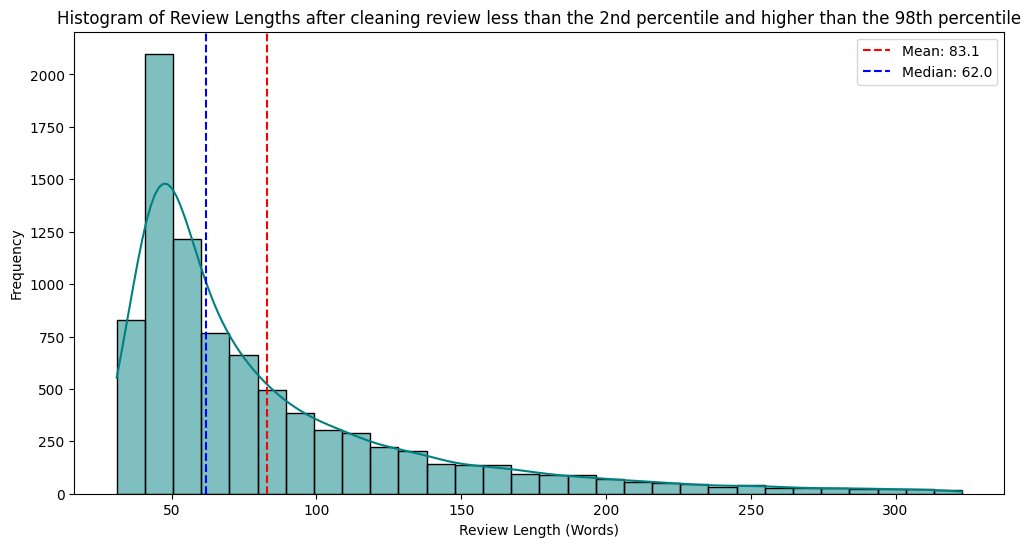

In [30]:
# calculate the mean and median for the review length after cleaning review less than teh 2nd percentile and higher than the 98th percentile
mean_length = df_cleaned['review_length'].mean()
median_length = df_cleaned['review_length'].median()

# Plot the histogram for review length
plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned['review_length'], bins= 30, kde=True, color="teal")
plt.axvline(mean_length, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_length:.1f}')
plt.axvline(median_length, color='blue', linestyle='--', linewidth=1.5, label=f'Median: {median_length:.1f}')

plt.title("Histogram of Review Lengths after cleaning review less than the 2nd percentile and higher than the 98th percentile")
plt.xlabel("Review Length (Words)")
plt.ylabel("Frequency")
plt.legend()

plt.show()

Shape of dataset after cleaning

In [31]:
df_cleaned.shape

(8630, 9)

Dataset after cleaning

In [32]:
df_cleaned.head(3)

,title,lang,Date,rating,helpfulVotes,text,PlaceName,PlaceRating,review_length
0,"Terrible experience. Waste of time, money and ...",en,2024-08,1,1,well no big no first of all before booking ple...,Ella Jungle Resort,4.0,275
1,Ella Jungle resort you should never miss!,en,2022-06,5,1,it is one of the most amazing stay we ever had...,Ella Jungle Resort,4.0,61
2,Must visit when in Ella,en,2024-10,5,0,i dont why there are negative reviews its a ju...,Ella Jungle Resort,4.0,151


Summary statistics for numerical columns after cleaning

In [33]:
print(df_cleaned[['rating', 'helpfulVotes', 'PlaceRating']].describe())

            rating  helpfulVotes  PlaceRating
count  8630.000000   8630.000000  8630.000000
mean      4.682155      0.211935     4.546929
std       0.796850      1.073246     0.311538
min       1.000000     -1.000000     4.000000
25%       5.000000      0.000000     4.500000
50%       5.000000      0.000000     4.500000
75%       5.000000      0.000000     4.500000
max       5.000000     60.000000     5.000000


Number of Hotels

In [34]:
num_hotels = df_cleaned['PlaceName'].nunique()
print(f"Number of Hotels: {num_hotels}")


Number of Hotels: 205


Number of Reviews per Hotel

In [35]:
reviews_per_hotel = df_cleaned.groupby('PlaceName').size()
print(reviews_per_hotel.describe())


count    205.000000
mean      42.097561
std        7.964397
min        9.000000
25%       38.000000
50%       45.000000
75%       48.000000
max       50.000000
dtype: float64


Total number of words and unique word counts

In [36]:
# Split all words in the 'text' column
all_words = ' '.join(df_cleaned['text']).split()
word_counts = Counter(all_words)

# Total words and unique words
total_words = len(all_words)
unique_words = len(word_counts)

print(f"Total Words: {total_words}")
print(f"Unique Words: {unique_words}")


Total Words: 716893
Unique Words: 19998


Most common 10 words and the count of each word

In [37]:
print(f'Most common words\n: {word_counts.most_common(10)}')

Most common words
: [('the', 46089), ('and', 33340), ('a', 18806), ('to', 17682), ('was', 15067), ('we', 11870), ('of', 10204), ('is', 9938), ('in', 9282), ('for', 8737)]


10 most common words excluding stopwords

In [39]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Join all review texts in resampled_data
all_text = " ".join(df_cleaned['text'].dropna())

# Split the text into words and remove stop words
words = [word.lower() for word in all_text.split() if word.lower() not in ENGLISH_STOP_WORDS]

# Count word frequencies
word_counts = Counter(words)

# Get the 10 most common words
common_words = word_counts.most_common(10)

# Convert to DataFrame for a neat table display
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

print("Top 10 Most Common Words (Excluding Stop Words):")
common_words_df


Top 10 Most Common Words (Excluding Stop Words):


,Word,Frequency
0,hotel,7459
1,staff,6674
2,food,4629
3,stay,4517
4,great,3882
5,room,3844
6,good,3756
7,service,3355
8,friendly,3086
9,rooms,2875


Generate word cloud

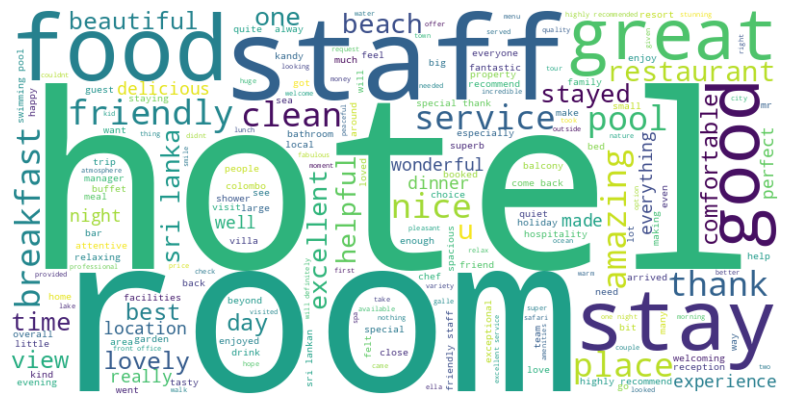

In [40]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

Histogram of Rating Distribution

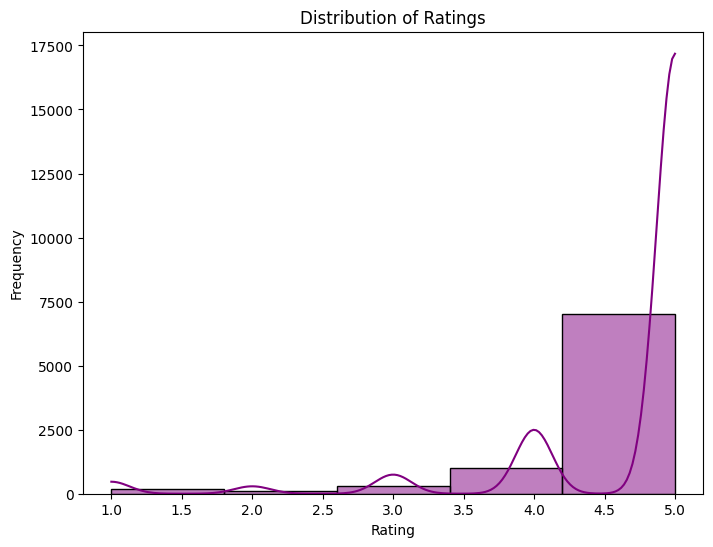

In [41]:
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['rating'], bins=5, kde=True, color='purple')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

Rating distribution as pie chart

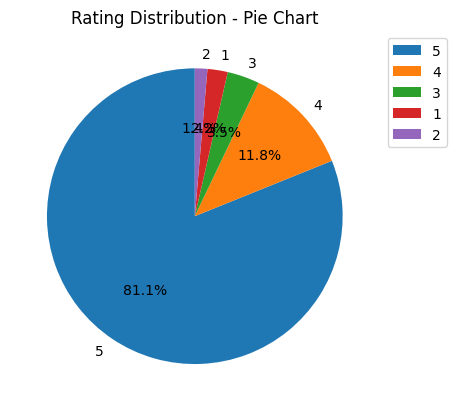

In [42]:
ratings_counts = df_cleaned['rating'].value_counts()
plt.pie(ratings_counts, labels=ratings_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Rating Distribution - Pie Chart')
plt.legend( loc = 'upper right', bbox_to_anchor=(1.2, 1))
plt.show()


Seasonal Trends: Average Rating by Month and Year

In [43]:
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
df_cleaned['month'] = df_cleaned['Date'].dt.month
df_cleaned['year'] = df_cleaned['Date'].dt.year

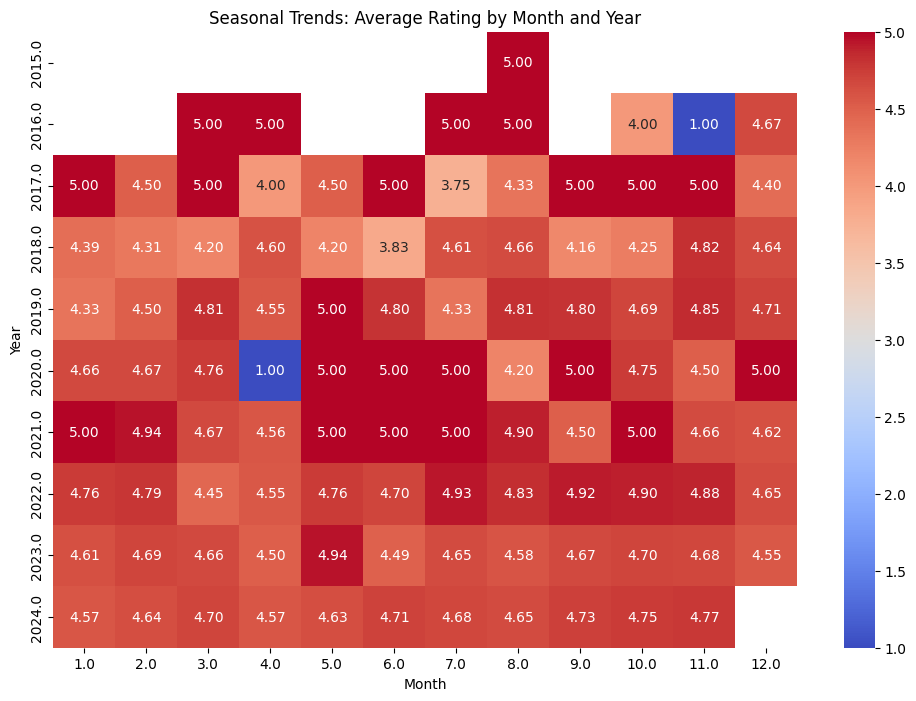

In [44]:
# Group by year and month, and get the average rating
monthly_yearly_ratings = df_cleaned.groupby(['year', 'month'])['rating'].mean().unstack()

# Plotting heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_yearly_ratings, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Seasonal Trends: Average Rating by Month and Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


In [45]:
columns_to_drop = ['year','month']
df_cleaned.drop(columns=columns_to_drop, inplace=True)

In [46]:
# Compute review length if not already done
df_cleaned['review_length'] = df_cleaned['text'].apply(lambda x: len(str(x).split()))

# Dataset Summary Table
dataset_summary = {
    "Total Reviews": [len(df_cleaned)],
    "Average Rating": [df_cleaned['rating'].mean()],
    "Average Place Rating": [df_cleaned['PlaceRating'].mean()],
    "Average Helpful Votes": [df_cleaned['helpfulVotes'].mean()],
    "Average Review Length (words)": [df_cleaned['review_length'].mean()],
    "Median Review Length (words)": [df_cleaned['review_length'].median()],
    "Total Words (cleaned reviews)": [df_cleaned['review_length'].sum()]
}

# Convert to DataFrame for a neat table display
summary_df = pd.DataFrame(dataset_summary)

print("Dataset Summary Table:")
summary_df


Dataset Summary Table:


,Total Reviews,Average Rating,Average Place Rating,Average Helpful Votes,Average Review Length (words),Median Review Length (words),Total Words (cleaned reviews)
0,8630,4.682155,4.546929,0.211935,83.069873,62.0,716893


Effectiveness of the different (subword) tokenization schemes

In [47]:
# Sample DataFrame
sample_df = df_cleaned.sample(n=2, random_state=42)  # 2 reviews from the  df

# Tokenization and stopword removal functions
def nltk_tokenization_stopwords(text):
    stop_words_nltk = set(stopwords.words('english'))
    tokenized_corpus_nltk = word_tokenize(text)
    tokenized_corpus_without_stopwords_nltk = [word for word in tokenized_corpus_nltk if word.lower() not in stop_words_nltk]
    return tokenized_corpus_without_stopwords_nltk

def spacy_tokenization_stopwords(text):
    spacy_model = spacy.load('en_core_web_sm')
    stopwords_spacy = spacy_model.Defaults.stop_words
    tokenized_corpus_spacy = [token.text for token in spacy_model(text)]
    tokenized_corpus_without_stopwords_spacy = [word for word in tokenized_corpus_spacy if word.lower() not in stopwords_spacy]
    return tokenized_corpus_without_stopwords_spacy

def gpt2_tokenization(text):
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    gpt2_tokens = gpt2_tokenizer.tokenize(text)
    return gpt2_tokens

def bert_tokenization(text):
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_tokens = bert_tokenizer.tokenize(text)
    return bert_tokens

In [48]:
# Apply tokenization methods to the sample review dataset
sample_df['nltk_tokens'] = sample_df['text'].apply(nltk_tokenization_stopwords)
sample_df['spacy_tokens'] = sample_df['text'].apply(spacy_tokenization_stopwords)
sample_df['gpt2_tokens'] = sample_df['text'].apply(gpt2_tokenization)
sample_df['bert_tokens'] = sample_df['text'].apply(bert_tokenization)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [49]:
# Print the tokenization comparison for the sampled dataset
print("Tokenization Comparison:")
for index, row in sample_df.iterrows():
    print("\nOriginal Review Text:")
    print(row['text'])
    print("\nNLTK Tokens (with stopwords removed):")
    print(row['nltk_tokens'])
    print("\nspaCy Tokens (with stopwords removed):")
    print(row['spacy_tokens'])
    print("\nGPT-2 Tokens (Byte-Pair Encoding):")
    print(row['gpt2_tokens'])
    print("\nBERT Tokens (WordPiece):")
    print(row['bert_tokens'])

Tokenization Comparison:

Original Review Text:
this place is awesome been here more than once and definitely will come back again staff ms kavishka was really helpful and kind too the rooms and common areas are really clean and tidy they have very kind and helpful staff members we all had a great stay here

NLTK Tokens (with stopwords removed):
['place', 'awesome', 'definitely', 'come', 'back', 'staff', 'ms', 'kavishka', 'really', 'helpful', 'kind', 'rooms', 'common', 'areas', 'really', 'clean', 'tidy', 'kind', 'helpful', 'staff', 'members', 'great', 'stay']

spaCy Tokens (with stopwords removed):
['place', 'awesome', 'definitely', 'come', 'staff', 'ms', 'kavishka', 'helpful', 'kind', 'rooms', 'common', 'areas', 'clean', 'tidy', 'kind', 'helpful', 'staff', 'members', 'great', 'stay']

GPT-2 Tokens (Byte-Pair Encoding):
['this', 'Ġplace', 'Ġis', 'Ġawesome', 'Ġbeen', 'Ġhere', 'Ġmore', 'Ġthan', 'Ġonce', 'Ġand', 'Ġdefinitely', 'Ġwill', 'Ġcome', 'Ġback', 'Ġagain', 'Ġstaff', 'Ġms', 'Ġk', 'a

In [50]:
#write cleaned dataset to csv file
df_cleaned.to_csv('cleaned_dataset.csv', index=False)

Explain the challenges encountered and the observations based on the output above



---



### Answer to Task 2

Describe the classification dataset, its dimensions, preprocessing steps, numbers of classes taken for classification, the which feature extraction techniques were performed.

In [ ]:
#Load the cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/NLP CW/cleaned_dataset.csv')

In [ ]:
#shape of the cleaned dataset
df.shape

(8630, 9)

In [ ]:
# cleaned dataset
df.head(2)

,title,lang,Date,rating,helpfulVotes,text,PlaceName,PlaceRating,review_length
0,"Terrible experience. Waste of time, money and ...",en,2024-08-01,1,1,well no big no first of all before booking ple...,Ella Jungle Resort,4.0,275
1,Ella Jungle resort you should never miss!,en,2022-06-01,5,1,it is one of the most amazing stay we ever had...,Ella Jungle Resort,4.0,61


## Preprocessing steps

1. Tokenization, Stopword Removal, and Lemmatization with spaCy (for Lexicon and ML Classifiers)
2. Subword Tokenization with GPT-2 for DL Classifier





Tokenization, Stopword Removal, and Lemmatization with spaCy

In [ ]:
# Load the SpaCy language model
nlp = spacy.load("en_core_web_sm")

def preprocess_spacy(text):
    doc = nlp(text)
    # Filter out stop words and non-alphabetic tokens --> lemmatize
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens
#Apply to text column and save the tokens to new column
df['lexicon_ml_tokens'] = df['text'].apply(preprocess_spacy)

Subword Tokenization with GPT-2


In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Tokenize each review into subwords
def gpt2_tokenize(text):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    return tokens

#Apply to text column and save the tokens to new column
df['dl_tokens'] = df['text'].apply(gpt2_tokenize)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

## Ground truth labelling process
1. Classifier 1 : Lexicon Based (VADER)
2. Classifier 2 : Lexicon Based (Bing-Liu-Sentiment)
3. Classifier 3 : DL-Based (distilbert-base-uncased-finetuned-sst-2-english)



*   Get majority Vote from VADER, DistilBERT, and Bing Liu Lexicon and get the final sentiment(Ground Truth)




Classifier 1: Lexicon-Based  -- VADER


In [ ]:
sia = SentimentIntensityAnalyzer()

# Function to get sentiment
def vader_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER sentiment analysis to text column
df['vader_sentiment'] = df['text'].apply(vader_sentiment)

# Display the results
print(df[['text', 'vader_sentiment']].head(3))

                                                text vader_sentiment
0  well no big no first of all before booking ple...        positive
1  it is one of the most amazing stay we ever had...        positive
2  i dont why there are negative reviews its a ju...        positive


Classifier 2: Lexicon-Based  -- bing_liu_sentiment

In [ ]:
# Load positive and negative words from the Bing Liu Lexicon
with open('/content/drive/MyDrive/NLP CW/negative-words.txt', 'r') as pos_file:
    positive_words = set(pos_file.read().splitlines())
with open('/content/drive/MyDrive/NLP CW/positive-words.txt', 'r') as neg_file:
    negative_words = set(neg_file.read().splitlines())


In [ ]:
def bing_liu_sentiment(tokens):
    tokens = [token.lower() for token in tokens]
    pos_count = sum(1 for word in tokens if word in positive_words)
    neg_count = sum(1 for word in tokens if word in negative_words)

    # Determine sentiment based on counts
    if pos_count > neg_count:
        return 'positive'
    elif neg_count > pos_count:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the 'lexicon_ml_tokens' column
df['bing_liu_sentiment'] = df['lexicon_ml_tokens'].apply(bing_liu_sentiment)

# Display the results
print(df[['text', 'bing_liu_sentiment']].head(3))


                                                text bing_liu_sentiment
0  well no big no first of all before booking ple...           positive
1  it is one of the most amazing stay we ever had...           negative
2  i dont why there are negative reviews its a ju...           negative


Classifier 3: DL-Based -- DistilBERT

In [ ]:
# Load the DistilBERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english",device=0)

def decode_and_analyze(tokens):
    # Decode the tokens back into text
    decoded_text = tokenizer.decode(tokens, skip_special_tokens=True)
    sentiment = sentiment_pipeline(decoded_text)[0]['label'].lower()
    return sentiment

# Apply the function to the 'dl_tokens' column
df['dl_sentiment'] = df['dl_tokens'].apply(decode_and_analyze)

# Display the results
print(df[['text', 'dl_sentiment']].head(3))

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                                text dl_sentiment
0  well no big no first of all before booking ple...     negative
1  it is one of the most amazing stay we ever had...     positive
2  i dont why there are negative reviews its a ju...     positive


 Majority Vote with VADER, DistilBERT, and Bing Liu Lexicon





In [ ]:
def final_majority_vote(row):
    sentiments = [row['vader_sentiment'], row['dl_sentiment'], row['bing_liu_sentiment']]
    return Counter(sentiments).most_common(1)[0][0]

# Apply majority voting
df['final_sentiment'] = df.apply(final_majority_vote, axis=1)


In [ ]:
# Drop the individual classifier sentiment columns
df.drop(columns=['vader_sentiment', 'bing_liu_sentiment', 'dl_sentiment'], inplace=True)


In [ ]:
#write labeled dataset to csv file
df.to_csv('labeled_dataset.csv', index=False)

In [ ]:
df.head(3)

,title,lang,Date,rating,helpfulVotes,text,PlaceName,PlaceRating,review_length,lexicon_ml_tokens,dl_tokens,final_sentiment
0,"Terrible experience. Waste of time, money and ...",en,2024-08-01,1,1,well no big no first of all before booking ple...,Ella Jungle Resort,4.0,275,"[big, book, comment, look, picture, post, prop...","[4053, 645, 1263, 645, 717, 286, 477, 878, 254...",positive
1,Ella Jungle resort you should never miss!,en,2022-06-01,5,1,it is one of the most amazing stay we ever had...,Ella Jungle Resort,4.0,61,"[amazing, stay, sri, lanka, exciting, surround...","[270, 318, 530, 286, 262, 749, 4998, 2652, 356...",positive
2,Must visit when in Ella,en,2024-10-01,5,0,i dont why there are negative reviews its a ju...,Ella Jungle Resort,4.0,151,"[not, negative, review, jungle, resort, live, ...","[72, 17666, 1521, 612, 389, 4633, 8088, 663, 2...",positive


In [ ]:
# Dataset Dimensions
num_rows = df.shape[0]
num_columns = df.shape[1]
print(f"\nDataset Dimensions: {num_rows} rows and {num_columns} columns")


Dataset Dimensions: 8630 rows and 12 columns


In [ ]:
# Distribution of Sentiment Classes
class_distribution = df['final_sentiment'].value_counts()
print("\nSentiment Class Distribution:")
print(class_distribution)

# Number of Classes for Classification
num_classes = class_distribution.shape[0]
print(f"\nNumber of Classes for Classification: {num_classes}")


Sentiment Class Distribution:
final_sentiment
positive    7995
negative     628
neutral        7
Name: count, dtype: int64

Number of Classes for Classification: 3


Pie chart of sentiment distribution

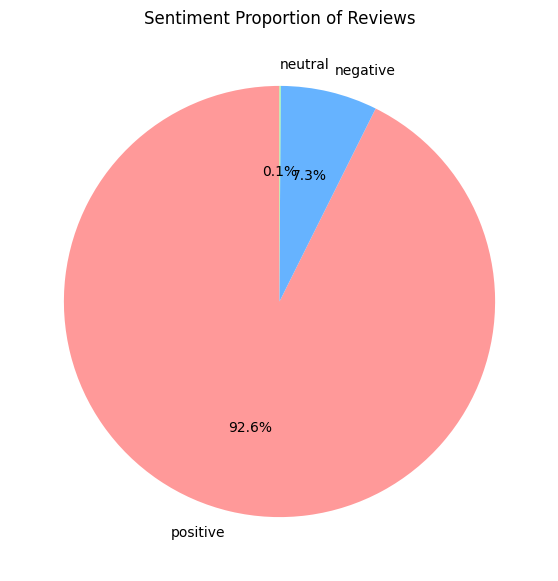

In [ ]:

sentiment_counts = df['final_sentiment'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set3', len(sentiment_counts)))
plt.title('Sentiment Proportion of Reviews')
plt.show()

### Answer to Task 3

Justify the 3 non-deep learning algorithms you are using for classification.

In [ ]:
#Load the cleaned dataset
df_labeled = pd.read_csv('/content/drive/MyDrive/NLP CW/labeled_dataset.csv')

Compare and interpret the results of the different algorithms and feature extraction methods on the text classification task.

### Answer to Task 4

Describe the contextual embedding used and it's effect on the performance of the algorithms selected in Task 3.

In [ ]:
# Insert code for Task 4

Compare the deep learning algorithm results with that of the 3 non-deep learning algorithms and interpret the overal results